In [1]:
from keras.datasets.cifar10 import load_data
# load_data() 的output是4個tuple要用4個變數去接
(x_train, y_train), (x_test, y_test) = load_data()

Using TensorFlow backend.


In [2]:
print("訓練資料:", x_train.shape) # 50000筆 長32 寬32 深度是3 RGB
print("測試資料:", x_test.shape)   
print("測試資料答案:", y_train.shape) #50000筆 每一筆1個答案(1個Output)
print("測試資料答案:", y_test.shape)
# 不信就自己印出x_train[99] y_train[99]看看

訓練資料: (50000, 32, 32, 3)
測試資料: (10000, 32, 32, 3)
測試資料答案: (50000, 1)
測試資料答案: (10000, 1)


In [0]:
# 原本y_train和y_test的output都是0~9的其中一個數字
# 希望寫一個字典對照 等一下去數字(key)來找Value
trans = {0:"飛機", 1:"汽車", 2:"鳥",
         3:"貓", 4:"鹿", 5:"狗",
         6:"青蛙", 7:"馬", 8:"船", 
         9:"卡車"}

In [4]:
print(type(y_train[100])) #y_train[100]雖然看起來是一個數字 但其實是一個numpy.ndarray 不過裡面只有一個東西
y_train[100][0] #用  XX[0]拿到裡面唯一的一個東西 output是真正的數字了

<class 'numpy.ndarray'>


8

這張是什麼? 貓


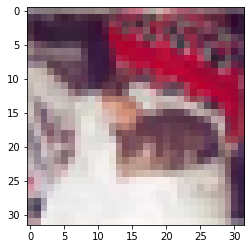

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
c = random.randint(0, 49999) # 隨機選一張
plt.imshow(x_train[c]) #印出圖片
print("這張是什麼?", trans[y_train[c][0]]) # 某字典[某key]， y_train[c][0]是一個數字

### 建立模型

#### 搭建CNN模型

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D       # (2D是因為長 寬)做卷積 
from keras.layers import MaxPooling2D # MaxPooling2D 做池化(有2D不要忘了)
from keras.layers import Flatten
cnn = Sequential()

#模型.add裡面 再做Conv2D、MaxPooling2D
cnn.add(Conv2D(filters = 32,          #filters設定有幾過濾器
               kernel_size = (3, 3), #kernel_size設定過濾器的寬 高通常是22或33
               padding="same",   #padding="same"就是做完過濾 原圖的寬高維持不變
               activation="relu",  #CNN 99%激活函數都選relu
               input_shape=(32, 32, 3)))  #CNN第一層是input_shape(寬,高,深度) 不一定是一維
                                          #普通MLP是input_dim 要攤平成一維
cnn.add(MaxPooling2D(pool_size=(2, 2))) #做池化
cnn.add(Conv2D(64, (3, 3), 
               padding="same", 
               activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# 要進MLP了 所以要攤開一維
cnn.add(Flatten())
cnn.add(Dense(256, activation="relu"))
cnn.add(Dropout(0.25))      #Dropout隨機丟失25% 這個動作可以防止Overfitting
cnn.add(Dense(10, activation="softmax"))
cnn.summary()
# 看參數896 、18496 有激活函數就有Bias記得加上1
#(3(寬) x 3(高) x 3(上一層的深度RGB)+1(Bias) ) x 32(個過濾器) = 28 x 32 = 896
# (3(寬) x 3(高) x 32(上一層深度)  +1(Bias)) x 64(個過濾器) = 289 x 64 =18496

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

#### 確定模型怎麼訓練

In [0]:
# 要對圖片做'分類' 答案是0~9的某數 所以categorical_crossentropy交叉熵 用機率看雜亂度
# 如果是二元分類時用binary_crossentropy
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

### 準備丟訓練資料和答案進去fit，但要對X Y做一些資料處理

#### X : 做CNN模型 ，餵進去的x不用攤開，2維的樣子丟進去就好

In [0]:
# 回憶:普通的MLP的input要攤平成1維
# (ex: 60000張 長28x寬28的圖要變成784) x_train_shape = x_train.reshape(60000, 784)
# 但CNN模型 一開始過濾的時候Conv2D是吃2維 所以不用reshape維度
x_train_norm = x_train / 255
x_test_norm = x_test / 255
# 都把0~255變成0~1

#### Y : CNN模型最後階段還是會做MLP，所以y跟MLP一樣要做one-hot encoding

In [9]:
# 要做one-hot encoding
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print("處理前會出現0~9:", y_train[99])
print("處理後猜的數字位置是1其他都是0:", y_train_cat[99])

處理前會出現0~9: [1]
處理後猜的數字位置是1其他都是0: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### 正式訓練模型

In [10]:
cnn.fit(x = x_train_norm, # x是訓練資料
        y = y_train_cat,  # y是訓練資料答案
        batch_size=200,   # batch_size是看幾筆資料調整一個參數(做梯度下降一次)通長都設100~200
        epochs=10,        # epochs是整份資料要看幾輪(epochs太多容易Overfitting)
        validation_split=0.1,   #validation_split通常是設定0.1 表示10%的題目考試 剩下的題目練習
        verbose=2)  # verbose可以設0(最安靜什麼都沒有) 1(有進度條) 2(沒進度條)

# 注意報表的val_loss開始沒什麼再下降就是開始Overfitting了 
# 如果想再訓練就再執行一次會接著訓練

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
 - 6s - loss: 1.6425 - accuracy: 0.4070 - val_loss: 1.3285 - val_accuracy: 0.5334
Epoch 2/10
 - 4s - loss: 1.2571 - accuracy: 0.5511 - val_loss: 1.1105 - val_accuracy: 0.6118
Epoch 3/10
 - 4s - loss: 1.1050 - accuracy: 0.6081 - val_loss: 1.0018 - val_accuracy: 0.6570
Epoch 4/10
 - 4s - loss: 1.0064 - accuracy: 0.6483 - val_loss: 0.9443 - val_accuracy: 0.6738
Epoch 5/10
 - 4s - loss: 0.9244 - accuracy: 0.6766 - val_loss: 0.9207 - val_accuracy: 0.6866
Epoch 6/10
 - 4s - loss: 0.8585 - accuracy: 0.6984 - val_loss: 0.8597 - val_accuracy: 0.7050
Epoch 7/10
 - 4s - loss: 0.7998 - accuracy: 0.7172 - val_loss: 0.8408 - val_accuracy: 0.7138
Epoch 8/10
 - 4s - loss: 0.7444 - accuracy: 0.7364 - val_loss: 0.8248 - val_accuracy: 0.7212
Epoch 9/10
 - 4s - loss: 0.7109 - accuracy: 0.7501 - val_loss: 0.8505 - val_accuracy: 0.7096
Epoch 10/10
 - 4s - loss: 0.6604 - accuracy: 0.7675 - val_loss: 0.8082 - val_accuracy: 0.7274


### 驗證模型

#### 拿測試資料丟進去 看重要的指標

In [11]:
cnn.evaluate(x_test_norm, y_test_cat)

10000/10000 [==============================] - 1s 123us/step


[0.8534717561721802, 0.7039999961853027]

#### 做預測 會跑出機率

In [12]:
# model.predict(x_test_shape)每筆資料會跑出10個機率 
print("預測機率:", cnn.predict(x_test_norm))
# model.predict_classes(x_test_shape) 機率最高的就會當作是預測答案
print("機率最高的就會當作是預測答案:", cnn.predict_classes(x_test_norm))

預測機率: [[5.6940003e-04 5.4523836e-05 1.2650196e-03 ... 1.8532101e-04
  1.4304686e-03 1.2527470e-04]
 [1.7291827e-02 5.8127332e-02 1.8551616e-06 ... 3.2752091e-08
  9.2398626e-01 5.8844127e-04]
 [1.5139133e-01 7.2381631e-02 7.0290378e-04 ... 3.2550906e-04
  7.6048177e-01 1.1054064e-02]
 ...
 [1.0264424e-04 2.8249317e-06 1.8578707e-01 ... 3.7694074e-02
  7.5306409e-05 8.7068358e-05]
 [2.2958318e-02 2.2828622e-01 1.8248938e-02 ... 1.9118809e-03
  1.0209698e-03 3.7207163e-03]
 [1.6399947e-05 1.0609065e-04 1.2682467e-03 ... 9.5743525e-01
  6.8976619e-06 1.5158086e-05]]
機率最高的就會當作是預測答案: [3 8 8 ... 5 4 7]


#### confusion_matrix

In [13]:
from sklearn.metrics import confusion_matrix
import pandas as pd
pre = cnn.predict_classes(x_test_norm) # 把預測的答案存成pre
pd.DataFrame(confusion_matrix(y_test, pre))
# 表格 左邊(直的)是正確答案y_true  上邊(橫的)是預測的答案y_pred

,0,1,2,3,4,5,6,7,8,9
0,763,15,51,30,7,5,12,9,75,33
1,21,793,11,25,2,9,5,3,34,97
2,62,4,580,111,57,82,44,31,15,14
3,19,5,54,623,32,184,45,17,9,12
4,27,3,93,129,547,62,52,70,15,2
5,18,2,45,232,23,626,12,32,6,4
6,7,3,44,127,20,26,760,5,6,2
7,17,2,38,60,33,99,4,732,2,13
8,44,35,18,23,3,14,7,5,832,19
9,35,65,15,29,2,13,8,16,33,784


0:飛機, 1:汽車, 2:鳥, 3:貓, 4:鹿, 5:狗, 6:青蛙, 7:馬, 8:船, 9:卡車

#### 對答案

In [19]:
print("你寫的答案", pre)
print("你寫的第100題答案:", pre[99])
print(pre.shape) #是10000筆 1維的東西

你寫的答案 [3 8 8 ... 5 4 7]
你寫的第100題答案: 7
(10000,)


In [20]:
print("正確的答案", y_test)
print("第100題的正確答案", y_test[99])  #[7] 不會等於 7
print(y_test.shape) #是10000筆 每個都是1維的list

正確的答案 [[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
第100題的正確答案 [7]
(10000, 1)


In [21]:
# 注意上面兩塊 要讓他們一樣才能用 !=比較是否相等
y_test.reshape(10000) #把原本的(10000, 1)變成(10000,)
#可以用一個變數接 或是像下面那塊直接用一次reshape

array([3, 8, 8, ..., 5, 1, 7])

#### 檢討:把錯的印出來

到底有幾個預測錯誤: 2960


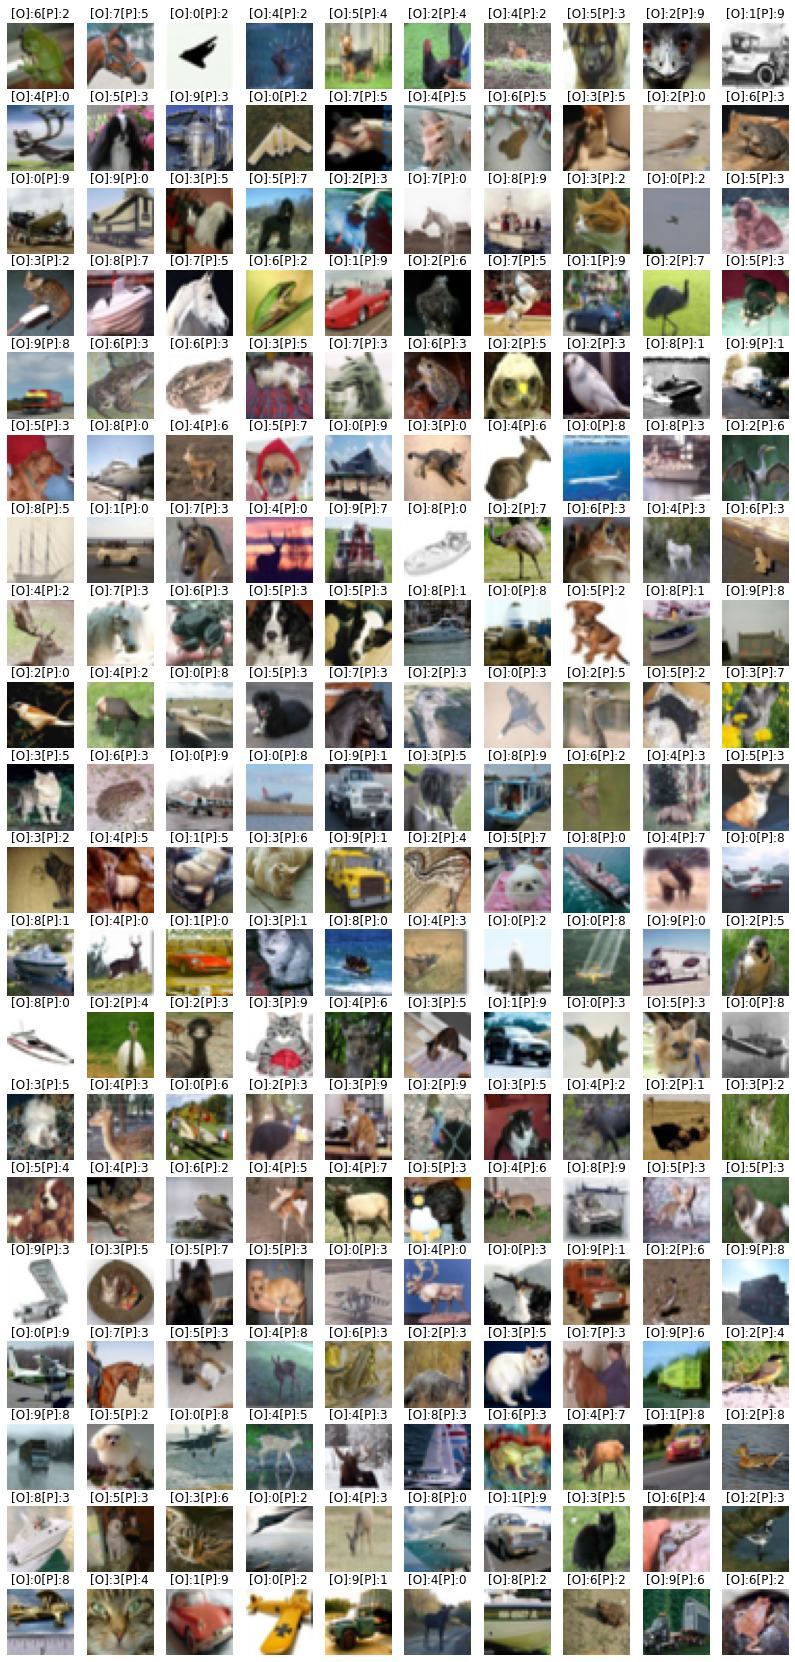

In [26]:
import numpy as np   #不能直接pre != y_test
false_index = np.nonzero(pre != y_test.reshape(10000))[0] # 你寫錯的題號
print("到底有幾個預測錯誤:", len(false_index))
false_img = x_test[false_index] # 用預測錯誤的索引 抓出你寫錯的題目

# ori_label是numpy array，ori_label[a]也還是是numpy array雖然整個array只有一個東西
# ori_label[a][0]才是數字
ori_label = y_test[false_index] # 用預測錯誤的索引 抓出你寫錯題目的答案
pre_label = pre[false_index]   #回憶:pre是預測的答案 用預測錯誤的索引 抓出錯的那幾題你寫了什麼答案

width = 10
height = int(len(false_index) / 10) + 1

# plt.figure是調整每張圖大小 很重要! 不然原圖太大或太小印出來會很怪
plt.figure(figsize=(14, 450))
#enumerate會把裡面的東西都變成tuple 要用2個變數接(看下面簡單的範例)
for (index, img) in enumerate(false_img[:200]): #false_img[:200]就是只拿前200張
    plt.subplot(height, width, index + 1)       #設定總高度 總寬度 第幾張圖片(+1是因為索引從0開始 第1張圖的index是0)
    msg = "[O]:" + str(ori_label[index][0]) + "[P]:" + str(pre_label[index]) #設定每張圖的標題
    #ori_label[a]是第a題的正確答案 ，pre_label[a]是第a題你寫了什麼答案

    plt.title(msg)
    plt.axis("off")#關掉x y軸
    plt.imshow(img)


0:飛機, 1:汽車, 2:鳥, 3:貓, 4:鹿, 5:狗, 6:青蛙, 7:馬, 8:船, 9:卡車

In [24]:
#enumerate( )範例
seq = ['one', 'two', 'three'] 
for i, element in enumerate(seq):      
    print(i, element)

0 one
1 two
2 three
